In [1]:
import sys
import numpy as np
import imageio
from matplotlib import pyplot as plt
import scipy.sparse
import scipy.sparse.linalg
import cv2

#To print all elements in an np array
np.set_printoptions(threshold=sys.maxsize)

Image = cv2.imread('./Images/office_noisy.png',0) 

#Resizing image to reduce the dimension of coeffiecient array while solving the pde
#resized_img = cv2.resize(Image,(90,90), interpolation = cv2.INTER_AREA)

#Adding zero borders to nullify boundary  conditions
padded_digit = cv2.copyMakeBorder(Image, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=0)

Lx, Ly = padded_digit.shape




In [2]:

"""
Solving 2D Isotropic linear diffusion equation:

      u_t = a*(u_xx + u_yy)   on  (0,Lx)x(0,Ly)

with boundary conditions in image domain u=0 on x=0,Lx and y=0,Ly for t in (0,T].
Initial condition: u(x,y,0)=I(x,y).

The following naming convention of variables are used.

============= ==========================================================
VariableName  Description
============= ==========================================================
Fx            Mesh Fourier number in x.
Fy            Mesh Fourier number in y.
Nx            Number of mesh cells in x direction.
Ny            Number of mesh cells in y direction.
dt            Desired time step.
T             Diffusion Time.
I             Image as a function of 2 dimention.
a             diffusivity (constant for Linear diffusion).
Lx            Length of the domain ([0,Lx]).
Ly            Length of the domain ([0,Ly]).
x             Mesh points in x.
y             Mesh points in y.
t             Mesh points in time.
n             Index counter in time.
u             Unknown at current/new time level.
u_n           u at the previous time level.
dx            Constant mesh spacing in x.
dy            Constant mesh spacing in y.
dt            Constant mesh spacing in t.
============= ==========================================================

The mesh points are numbered as (0,0), (1,0), (2,0),
..., (Nx,0), (0,1), (1,1), ..., (Nx,1), ..., (0,Ny), (1,Ny), ...(Nx,Ny).
2D-index i,j maps to a single index k = j*(Nx+1) + i, where i,j is the
node ID and k is the corresponding location in the solution array u (or u1).


user_action: function of (u, x, y, t, n) called at each time
level (x and y are one-dimensional coordinate vectors).
This function allows the calling code to plot the solution,
compute errors, etc.
"""


def solver_classic_iterative(
    I, a, f, Lx, Ly, Nx, Ny,dt, T, theta=0.5,
    U_0x=0, U_0y=0, U_Lx=0, U_Ly=0, user_action=None, max_iter=100, tol=1E-4):
    
    """ Solving using the theta-rule difference approximation in time - Jacobi """
    
    version='vectorized'
    iteration='Jacobi'
    omega=1.0
    
    x = np.linspace(0, Lx, Nx+1)       # mesh points in x dir
    y = np.linspace(0, Ly, Ny+1)       # mesh points in y dir
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    

    dt = float(dt)                    # avoid integer division
    Nt = int(round(T/float(dt)))
    t = np.linspace(0, Nt*dt, Nt+1)   # mesh points in time

    # Mesh Fourier numbers in each direction
    Fx = a*dt/dx**2
    Fy = a*dt/dy**2

    # Allow f to be None or 0
    if f is None or f == 0:
        f = lambda x, y, t: np.zeros((x.size, y.size)) \
            if isinstance(x, np.ndarray) else 0


    u   = np.zeros((Nx+1, Ny+1))      # unknown u at new time level
    u_n = np.zeros((Nx+1, Ny+1))      # u at the previous time level
    u_  = np.zeros((Nx+1, Ny+1))      # most recent approx to u
  
    u_new = np.zeros((Nx+1, Ny+1))  # help array

    Ix = range(0, Nx+1)
    Iy = range(0, Ny+1)
    It = range(0, Nt+1)

    # Make U_0x, U_0y, U_Lx and U_Ly functions if they are float/int
    if isinstance(U_0x, (float,int)):
        _U_0x = float(U_0x)  # Make copy of U_0x
        U_0x = lambda t: _U_0x
    if isinstance(U_0y, (float,int)):
        _U_0y = float(U_0y)  # Make copy of U_0y
        U_0y = lambda t: _U_0y
    if isinstance(U_Lx, (float,int)):
        _U_Lx = float(U_Lx)  # Make copy of U_Lx
        U_Lx = lambda t: _U_Lx
    if isinstance(U_Ly, (float,int)):
        _U_Ly = float(U_Ly)  # Make copy of U_Ly
        U_Ly = lambda t: _U_Ly

    # Load initial condition into u_n
    for i in Ix:
        for j in Iy:
            u_n[i,j] = I[i][j]
            

    # Two-dim coordinate arrays for vectorized function evaluations
    # in the user_action function
    xv = x[:,np.newaxis]
    yv = y[np.newaxis,:]


    # Time loop
    import scipy.linalg
    for n in It[0:-1]:
        # Solve linear system by Jacobi or SOR iteration at time level n+1
        u_[:,:] = u_n  # Start value
        converged = False
        r = 0
        while not converged:
            
        #    if version == 'vectorized':
            j = 0;  u[:,j] = U_0y(t[n+1])  # boundary
            i = 0;  u[i,:] = U_0x(t[n+1])  # boundary
            i = Nx; u[i,:] = U_Lx(t[n+1])  # boundary
            j = Ny; u[:,j] = U_Ly(t[n+1])  # boundary
                # Internal points
            f_a_np1 = f(xv, yv, t[n+1])
            f_a_n   = f(xv, yv, t[n])
            def update(u_, u_n, ic, im1, ip1, jc, jm1, jp1):
                   
                return \
                1.0/(1.0 + 2*theta*(Fx + Fy))*(theta*(
                    Fx*(u_[ip1,jc] + u_[im1,jc]) +
                    Fy*(u_[ic,jp1] + u_[ic,jm1])) +\
                u_n[ic,jc] + (1-theta)*(
                    Fx*(u_n[ip1,jc] - 2*u_n[ic,jc] + u_n[im1,jc]) +\
                    Fy*(u_n[ic,jp1] - 2*u_n[ic,jc] + u_n[ic,jm1]))+\
                    theta*dt*f_a_np1[ic,jc] + \
                    (1-theta)*dt*f_a_n[ic,jc])

              #  if iteration == 'Jacobi':
            ic  = jc  = slice(1,-1)
            im1 = jm1 = slice(0,-2)
            ip1 = jp1 = slice(2,None)
            u_new[ic,jc] = update(u_, u_n, ic, im1, ip1, jc, jm1, jp1)
            u[ic,jc] = omega*u_new[ic,jc] + (1-omega)*u_[ic,jc]
                

            r += 1
            converged = np.abs(u-u_).max() < tol or r >= max_iter
            #print r, np.abs(u-u_).max(), np.sqrt(dx*dy*np.sum((u-u_)**2))
            u_[:,:] = u
     
        #print('t=%.2f: %s %s (omega=%g) finished in %d iterations' %(t[n+1], version, iteration, omega, r))


        # Update u_n before next step
        u_n, u = u, u_n

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(u, 'gray') 
    plt.title('Image At' + str(T) + 'Time Steps')
    plt.xticks([]),plt.yticks([])
    
    return u


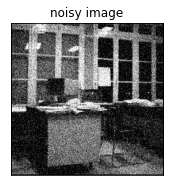

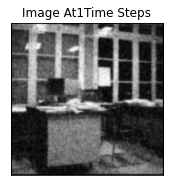

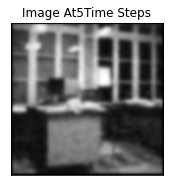

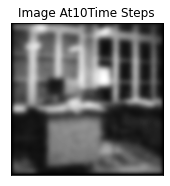

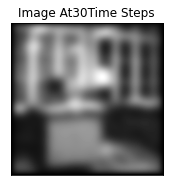

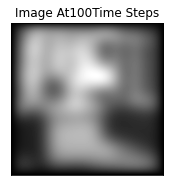

In [3]:
T =[{"time":1, "dt": 0.25},{"time": 5, "dt": 0.25}, {"time":10, "dt":0.25 }, {"time":30, "dt": 1 }, {"time":100, "dt": 1 }]
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(padded_digit, 'gray') 
plt.title('noisy image')
plt.xticks([]),plt.yticks([])

for time in T:
   
    solver_classic_iterative(padded_digit, 1, 0, Lx, Ly, Lx-1, Ly-1,time["dt"], time["time"], theta=0.5,U_0x=0, U_0y=0, U_Lx=0, U_Ly=0, user_action=None, max_iter=100, tol=1E-4)

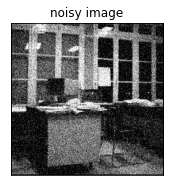

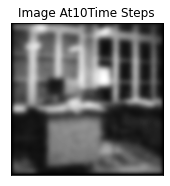

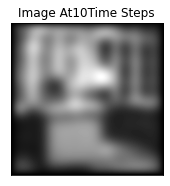

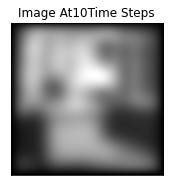

In [4]:
D =[1, 5, 10]
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(padded_digit, 'gray') 
plt.title('noisy image')
plt.xticks([]),plt.yticks([])

for d in D:
   
    solver_classic_iterative(padded_digit, d, 0, Lx, Ly, Lx-1, Ly-1,0.25, 10, theta=0.5,U_0x=0, U_0y=0, U_Lx=0, U_Ly=0, user_action=None, max_iter=100, tol=1E-4)

4.47213595499958
(258, 258)
(258, 258)
[[ 15  23  34  46  48  48  46  41  38  38  37  39  41  39  36  35  39  38
   39  43  43  40  40  38  36  35  34  36  40  40  42  46  48  50  55  61
   66  70  74  74  70  69  71  75  84  91  96  95  93  92  94  93  92  94
   90  85  82  80  72  61  53  42  33  27  27  26  31  30  30  29  27  19
   19  19  24  30  38  49  55  57  59  60  57  55  52  45  38  35  30  30
   32  30  25  24  20  21  22  23  25  26  22  25  25  26  27  30  29  28
   24  21  17  17  18  22  27  36  46  51  54  53  53  50  45  36  33  28
   21  19  22  22  25  26  33  34  30  24  26  27  31  42  44  45  44  44
   36  32  31  27  21  20  24  19  17  17  16  11  15  14  12  15  21  21
   22  24  24  19  17  15  13  10  10  16  22  29  33  42  47  50  54  50
   40  28  21  11  10  12  13  13  12  13  13   9   8   8   6   4   7   5
    6   9  10   9  11  15  18  22  28  32  35  31  31  30  25  25  25  24
   19  21  21  25  24  30  32  32  31  32  31  32  33  31  33  27  24  19

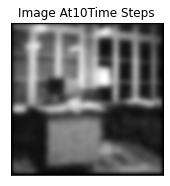

In [5]:
from math import sqrt

t = 10
σ = sqrt(2*t)
print(σ)

gaussianBlurredImage = cv2.GaussianBlur(padded_digit, (5,5), σ, borderType=cv2.BORDER_CONSTANT)
isotropicLinearDiffImage = solver_classic_iterative(padded_digit, 1, 0, Lx, Ly, Lx-1,Ly-1,0.1, t, theta=0.5,U_0x=0, U_0y=0, U_Lx=0, U_Ly=0, user_action=None, max_iter=100, tol=1E-4)

DiffImage = isotropicLinearDiffImage.astype('uint8')
print(gaussianBlurredImage.shape)
print(isotropicLinearDiffImage.shape)
print(gaussianBlurredImage)
print("------------------------------------------------------------------------------------------")
print(DiffImage)

def is_similar(image1, image2):
   
    return image1.shape == image2.shape and not(np.bitwise_xor(image1,image2).any())

print(is_similar(gaussianBlurredImage,DiffImage))


